### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/rhode_island/2023_07_14_09_36_42/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/rhode_island/2023_07_14_09_36_42/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.loc[person_time.scenario == 'baseline']
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2023,29,1868.276523
1,25_to_29,Female,2023,232,3724.517454
2,25_to_29,Female,2023,357,1953.982204
3,25_to_29,Female,2023,394,5612.188912
4,25_to_29,Female,2023,602,7529.221081


In [5]:
%%capture
for sex in per_time_group.sex.unique():
    for age in per_time_group.age.unique():
        plt.figure() 
        subdata = per_time_group.loc[(per_time_group.sex==sex) & (per_time_group.age==age)]
        plt.plot(subdata['year'], subdata['ptvalue'], marker='o')
        #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Person Time: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,300000)
        plt.grid()

### BMI

In [6]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,54993.339026
1,1,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,lifestyle_100,25_to_29,54993.339026
2,2,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,outreach_100,25_to_29,54993.339026
3,3,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,polypill_100,25_to_29,54993.339026
4,4,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,55055.333648


In [7]:
bmi_exp = risk_exp.loc[(risk_exp['risk']=='high_body_mass_index_in_adults') & (risk_exp['scenario']=='baseline')]
bmi_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,54993.339026
4,4,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,55055.333648
8,8,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,50434.618662
12,12,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,47227.211634
16,16,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,48067.869137


In [8]:
bmi_exp_summ = (bmi_exp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_exp_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,142761.460344,55574.852472,263923.086826
1,25_to_29,Female,2024,140028.201531,54665.391219,258124.313725
2,25_to_29,Female,2025,136682.350642,52963.952720,252861.150916
3,25_to_29,Female,2026,134489.992408,51918.404620,247184.328205
4,25_to_29,Female,2027,131879.790070,50094.733118,241450.788776


In [9]:
%%capture
for sex in bmi_exp_summ.sex.unique():
    for age in bmi_exp_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_summ.loc[(bmi_exp_summ.sex==sex) & (bmi_exp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [10]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']

In [11]:
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

,age,sex,year,mean,50%,2.5%,97.5%
0,25_to_29,Female,2023,29.147268,29.172955,28.632787,29.586874
1,25_to_29,Female,2024,29.129410,29.176382,28.597396,29.533642
2,25_to_29,Female,2025,29.125095,29.134856,28.616158,29.594360
3,25_to_29,Female,2026,29.151332,29.142163,28.763173,29.542137
4,25_to_29,Female,2027,29.121211,29.080489,28.748893,29.517187


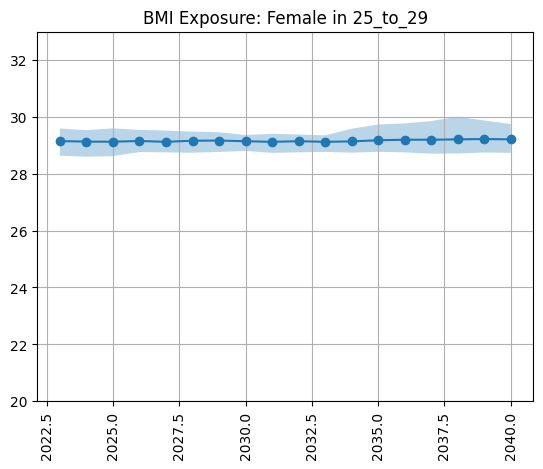

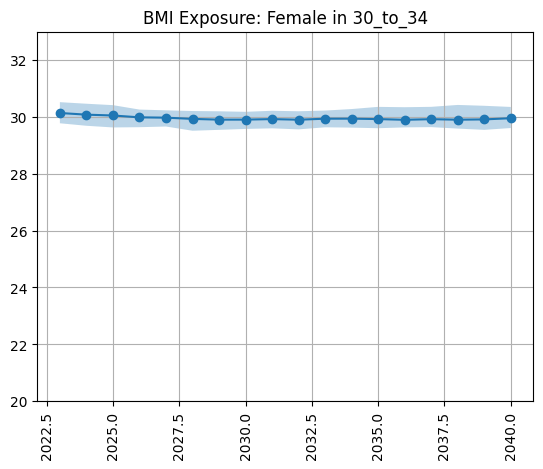

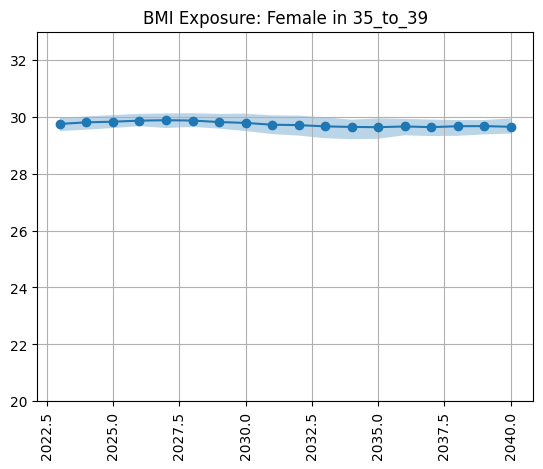

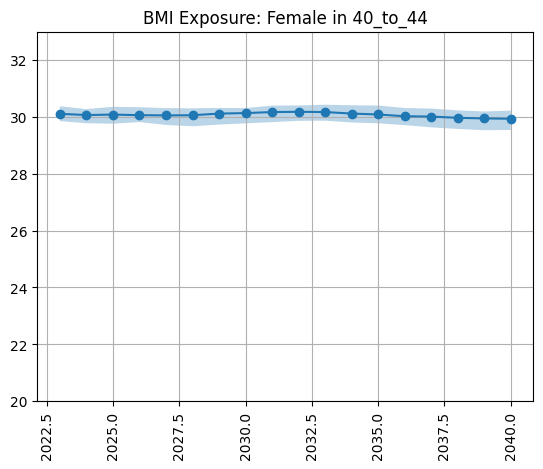

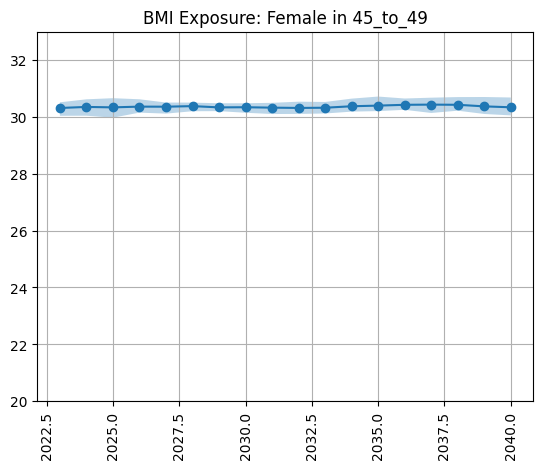

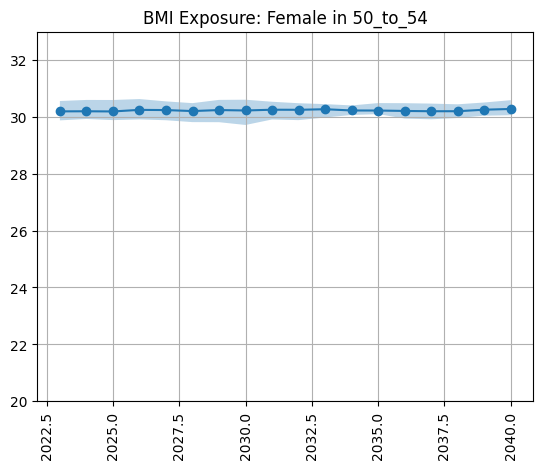

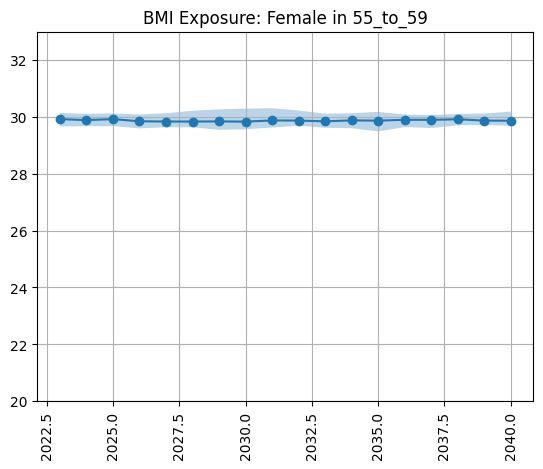

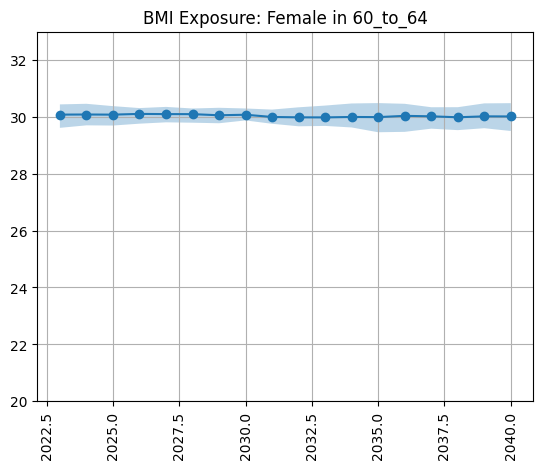

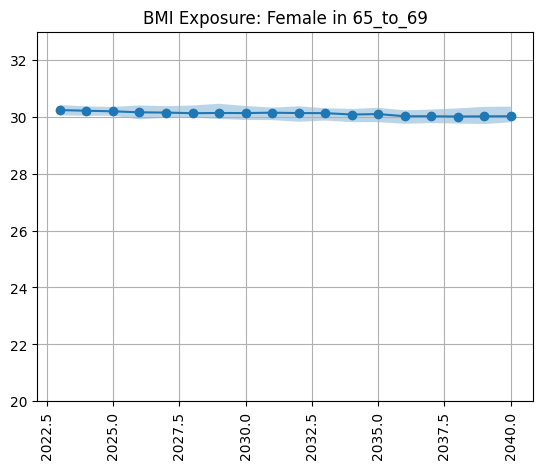

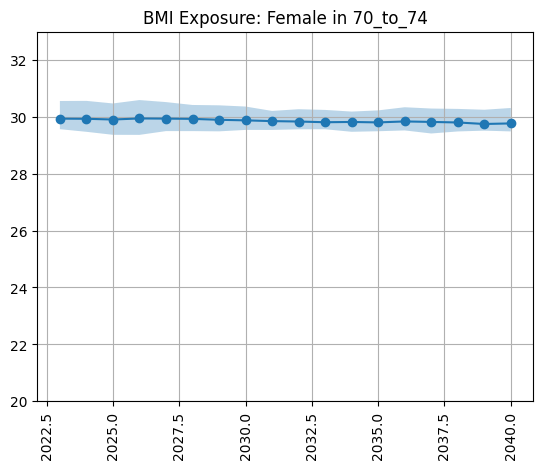

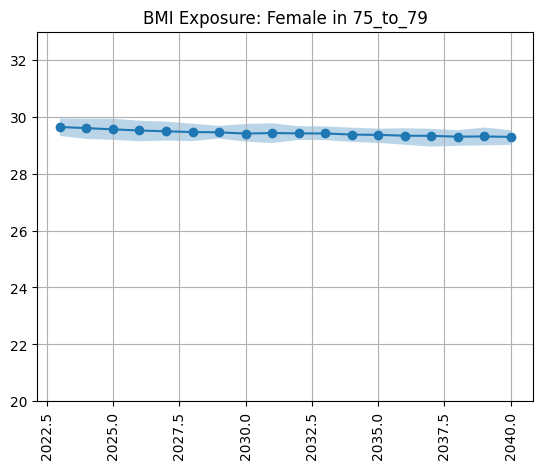

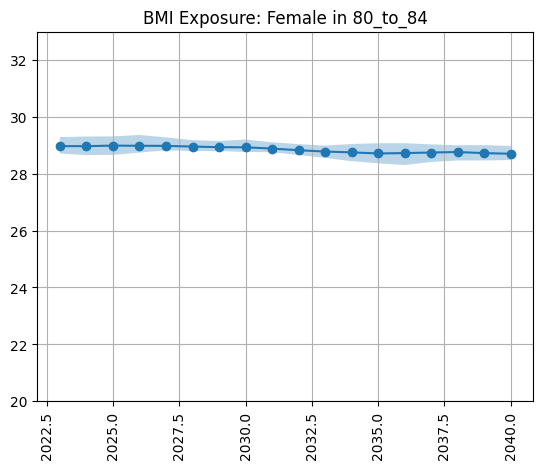

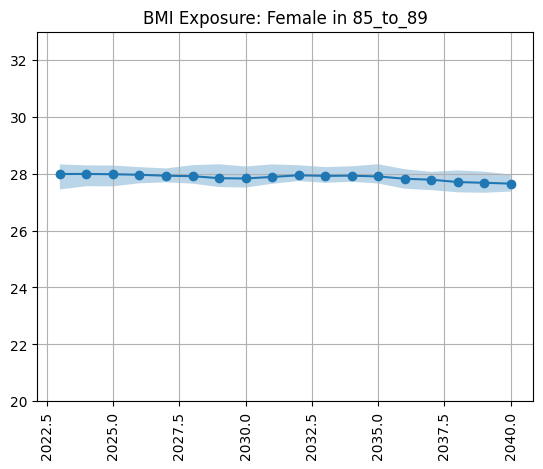

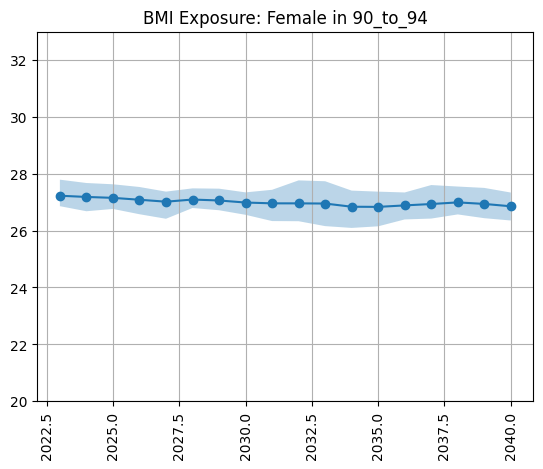

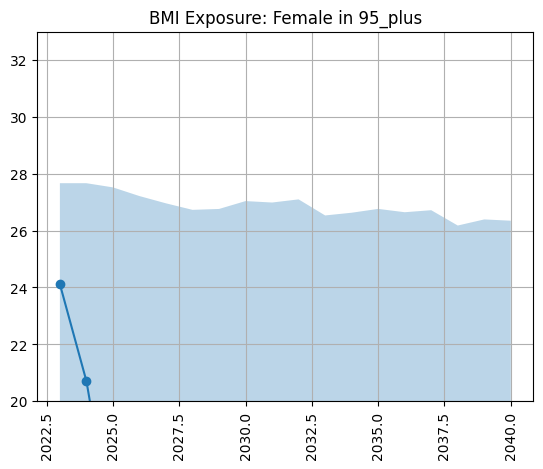

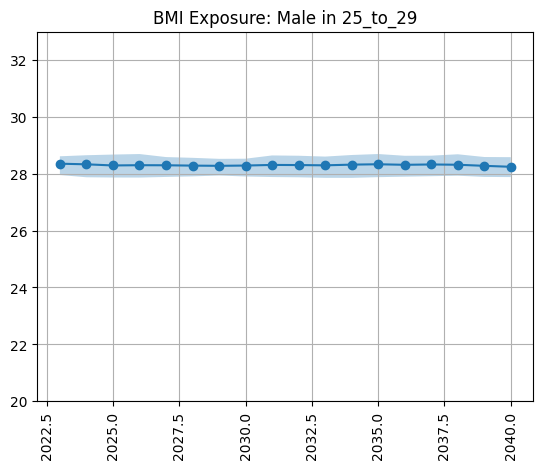

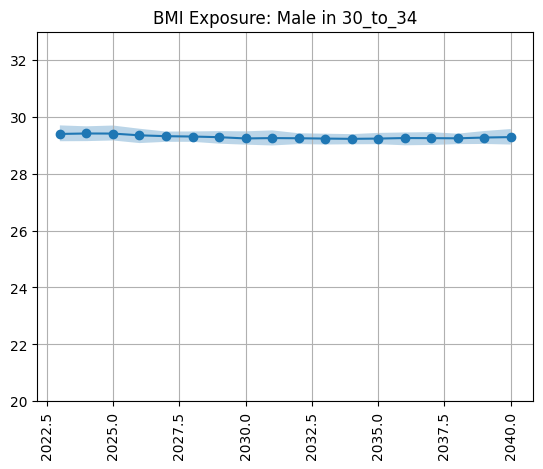

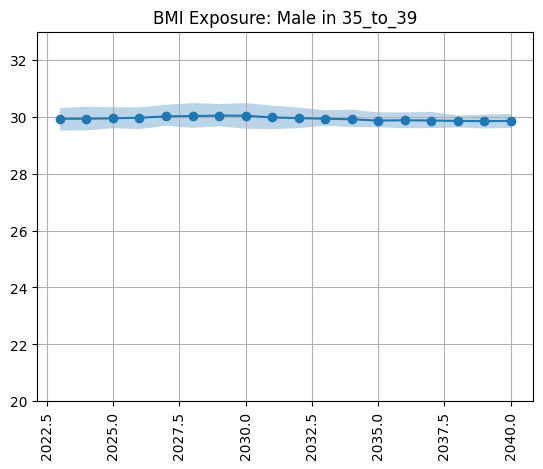

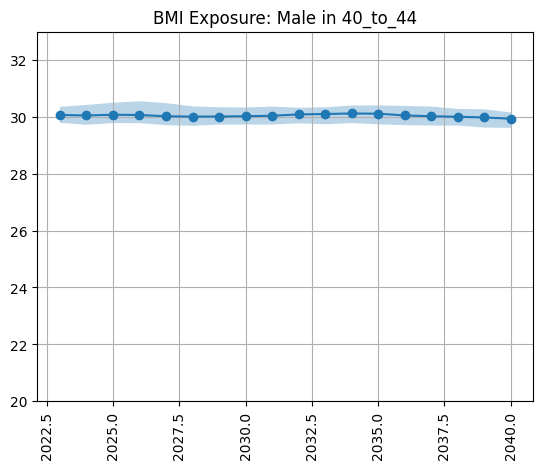

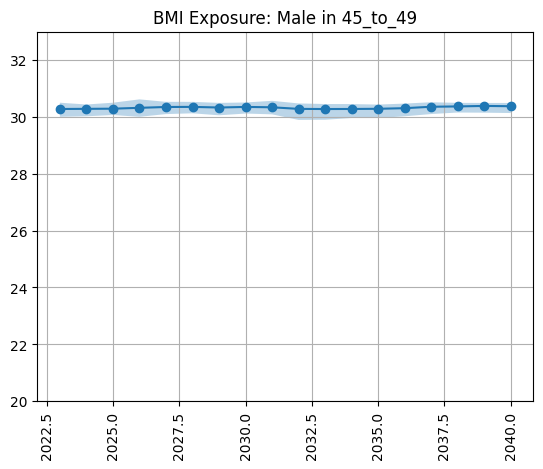

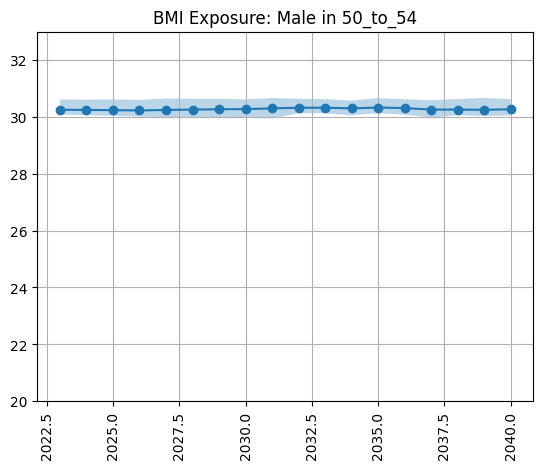

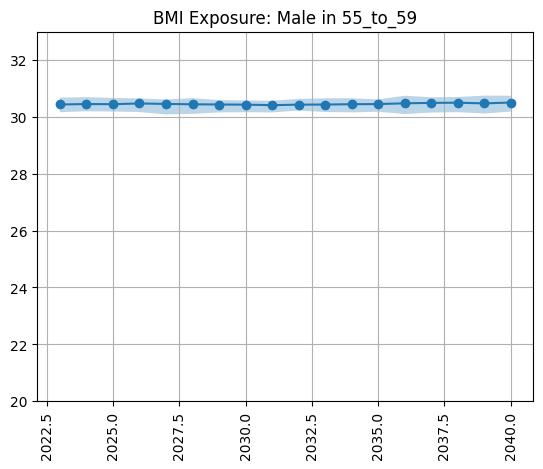

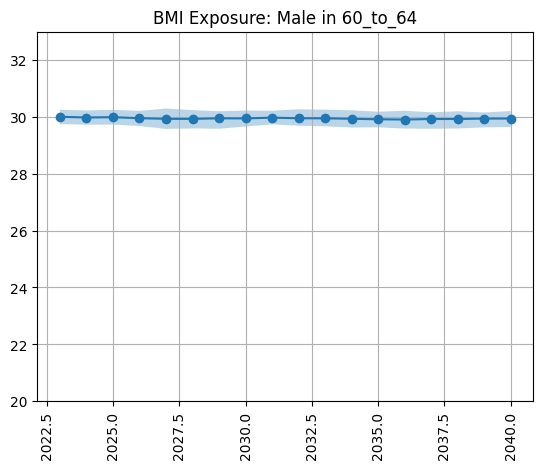

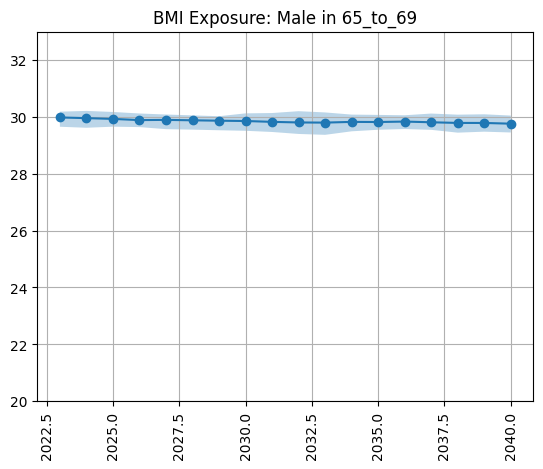

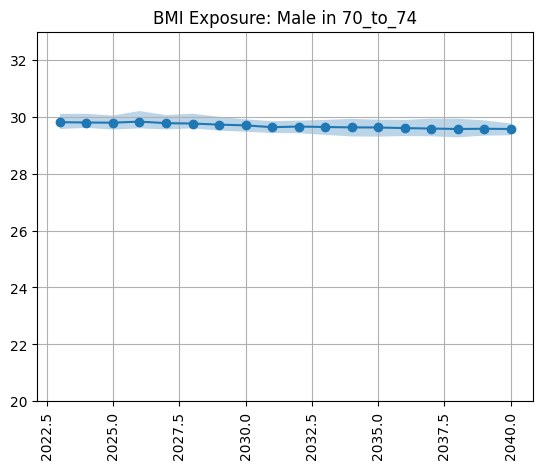

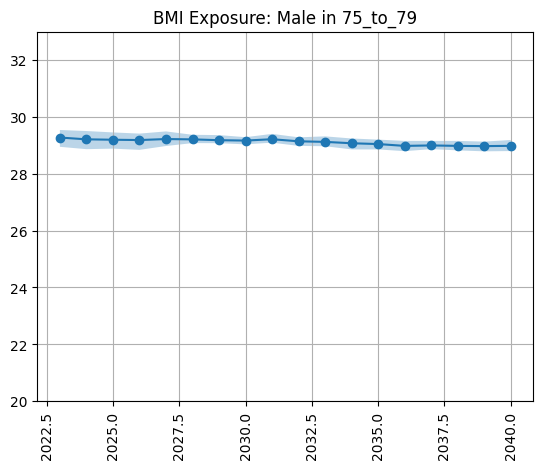

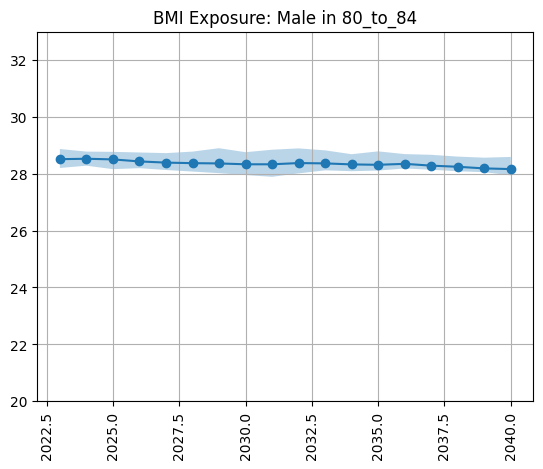

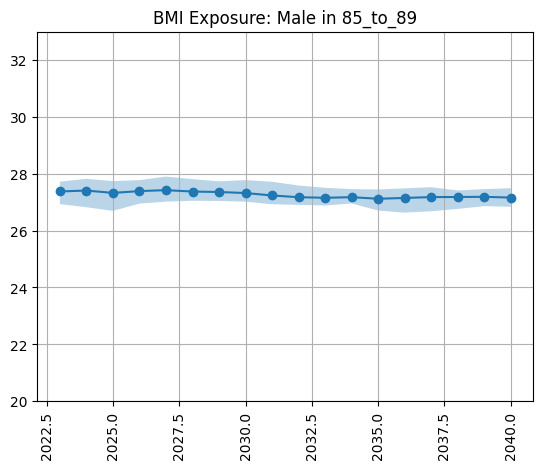

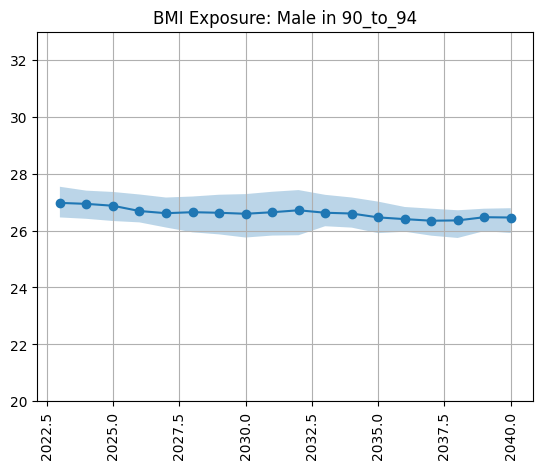

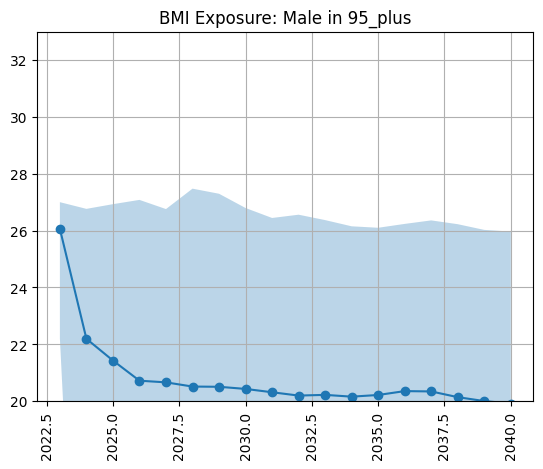

In [12]:
#%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(20,33)
        plt.grid()

Older people are getting lower BMI's overtime - that is bad 

### SBP 

In [13]:
sbp_exp = risk_exp.loc[(risk_exp['risk']=='high_systolic_blood_pressure') & (risk_exp['scenario']=='baseline')]
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']

In [14]:
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean','50%', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

,age,sex,year,mean,50%,2.5%,97.5%
0,25_to_29,Female,2023,109.315141,109.182834,107.162488,111.817509
1,25_to_29,Female,2024,109.240241,109.114171,106.948639,111.690105
2,25_to_29,Female,2025,109.272343,109.140079,107.081630,111.771610
3,25_to_29,Female,2026,109.327287,109.288651,107.134267,111.829387
4,25_to_29,Female,2027,109.249430,109.229172,106.920813,111.639504


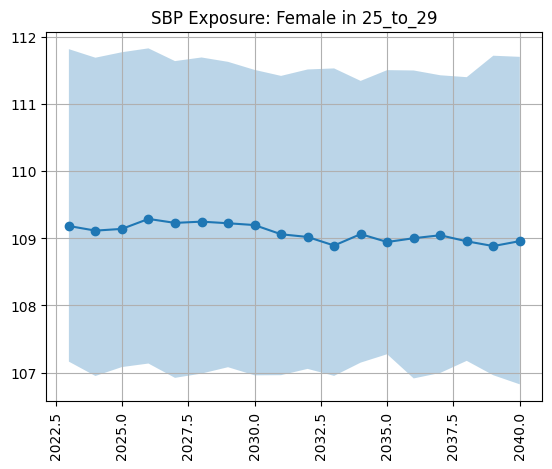

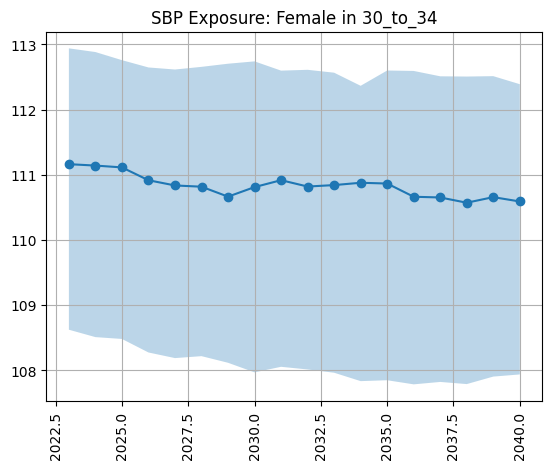

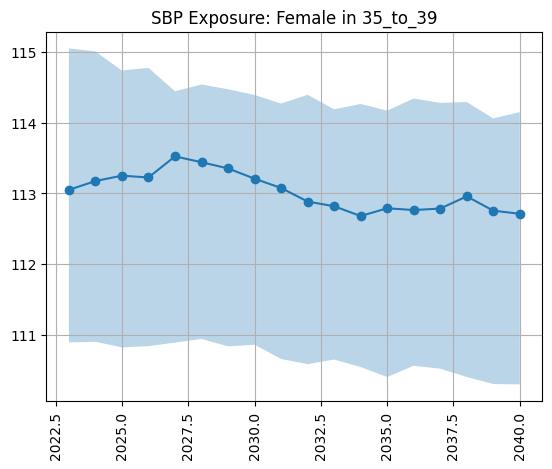

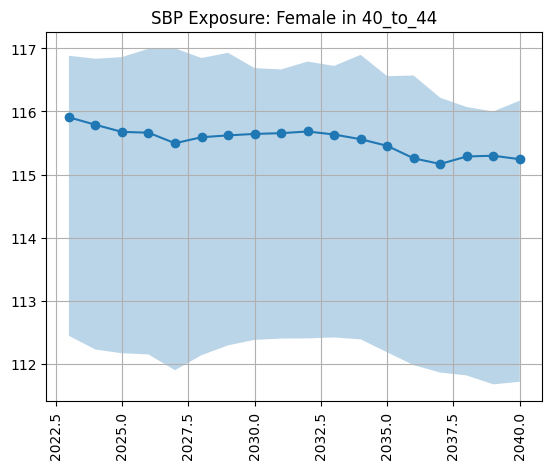

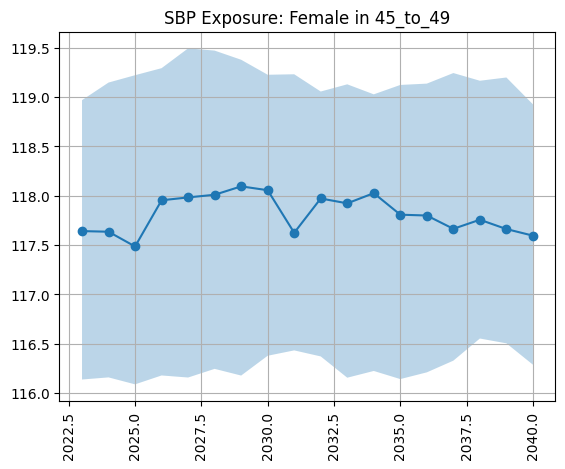

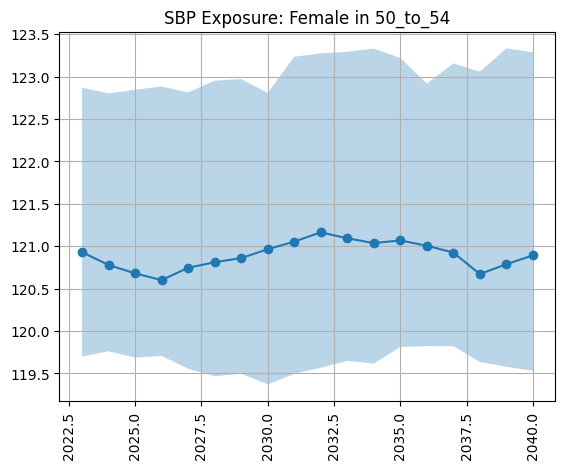

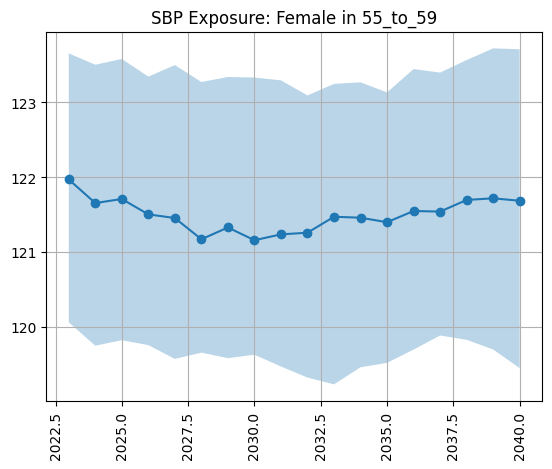

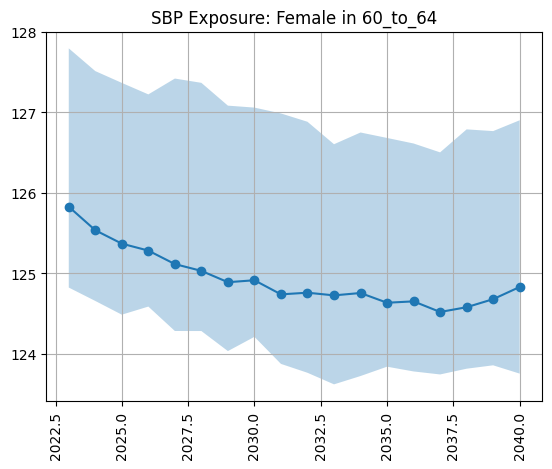

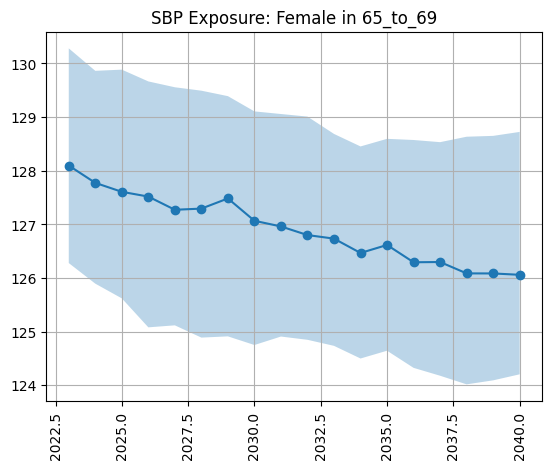

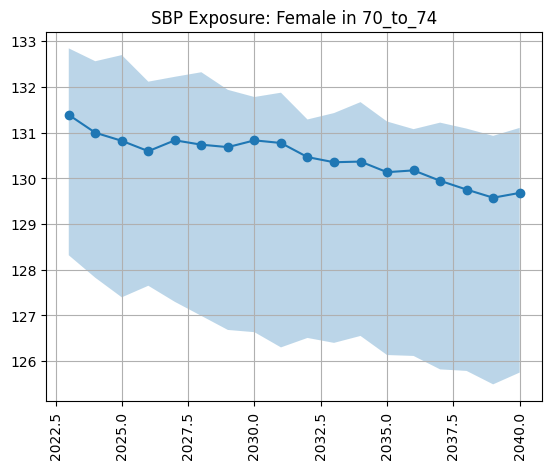

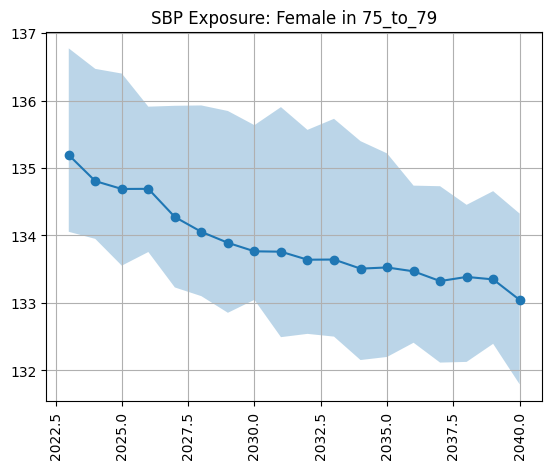

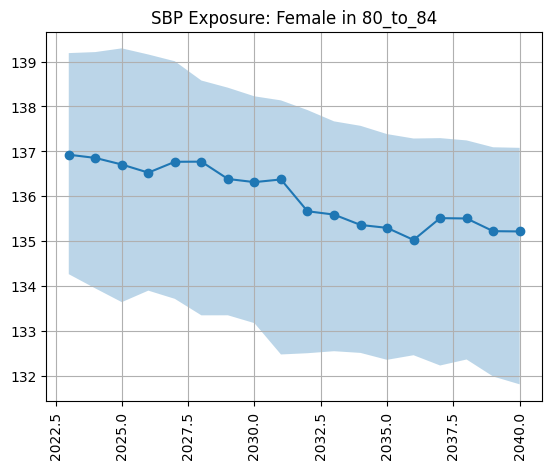

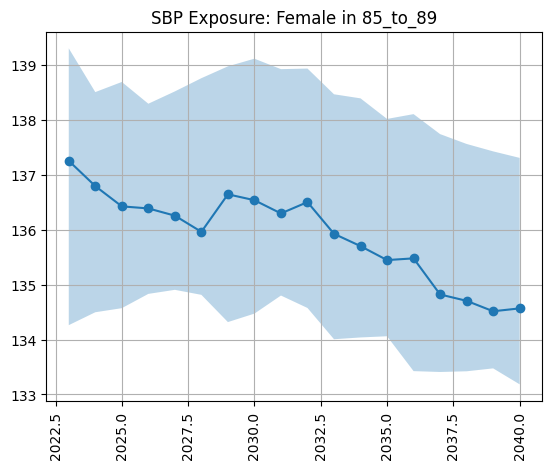

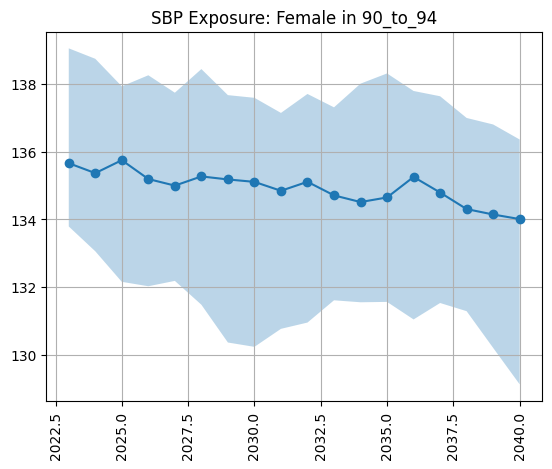

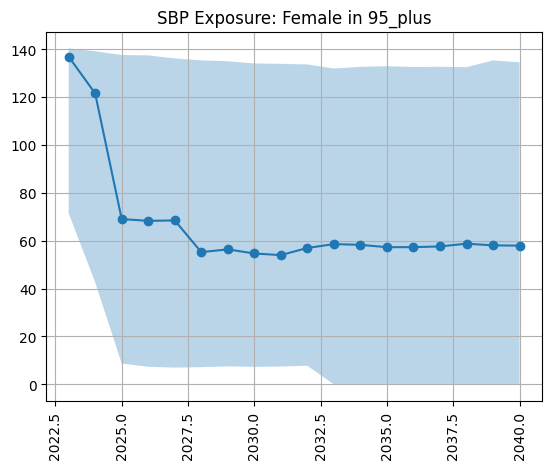

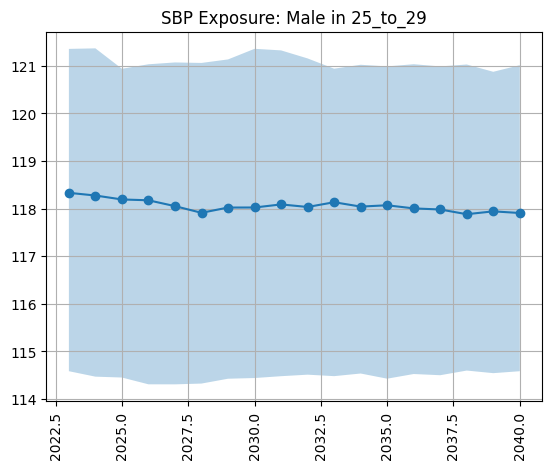

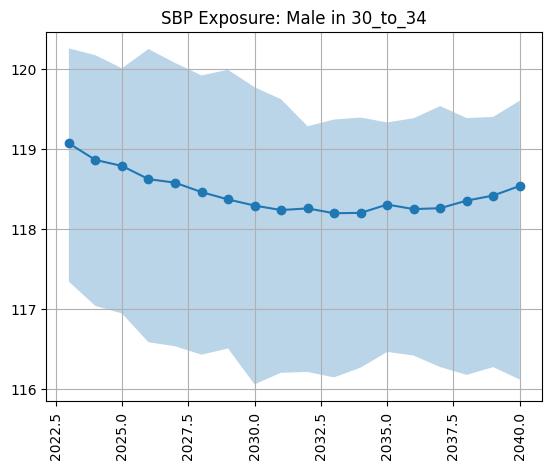

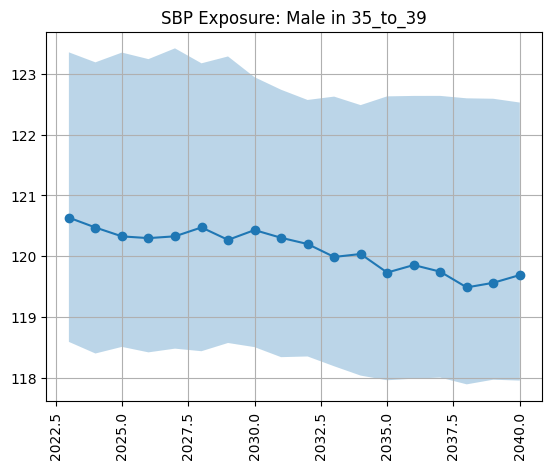

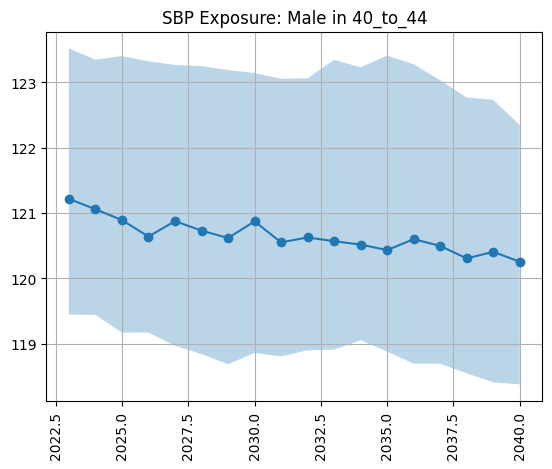

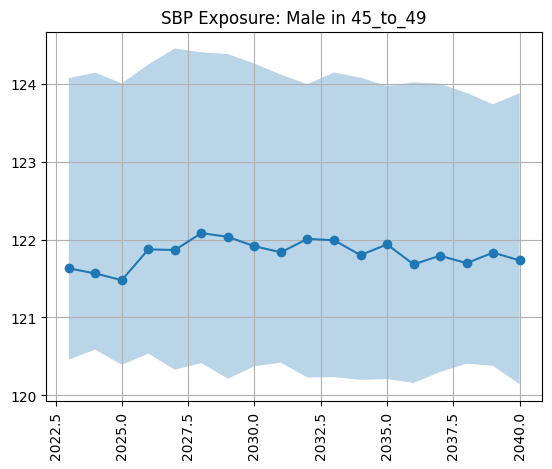

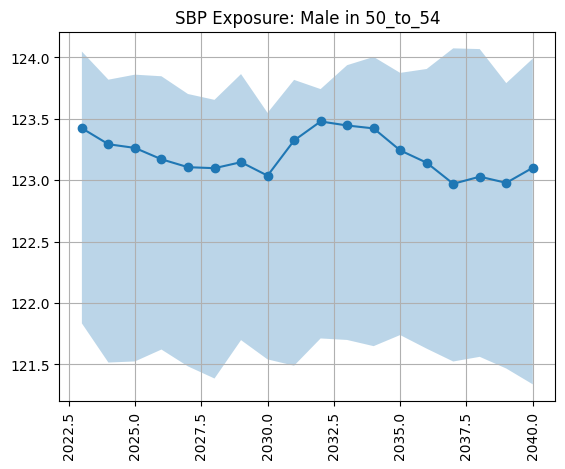

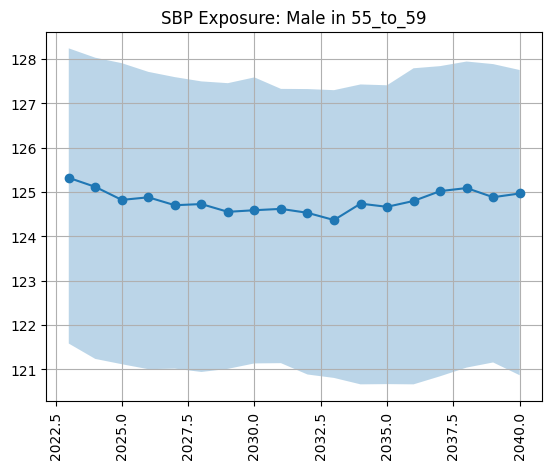

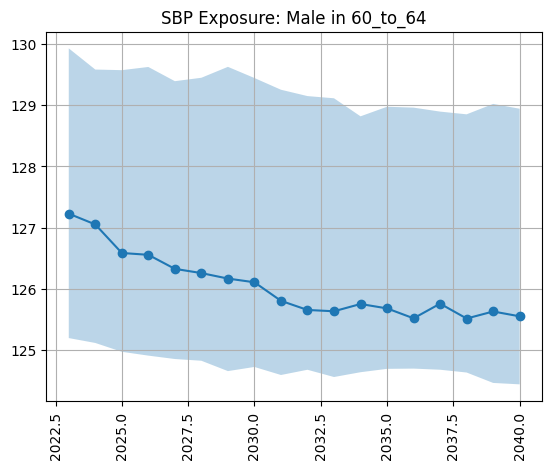

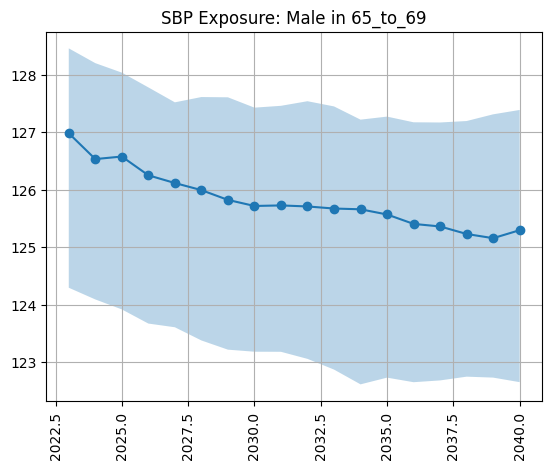

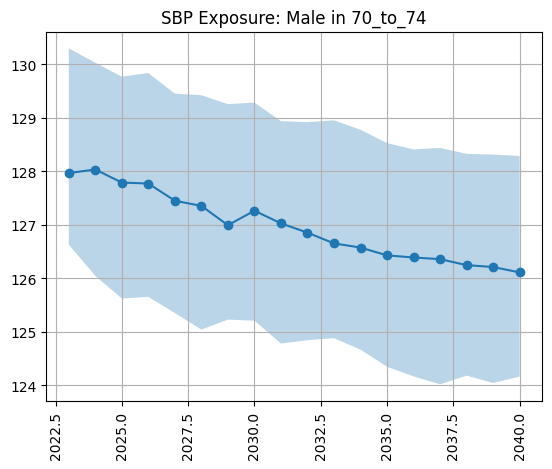

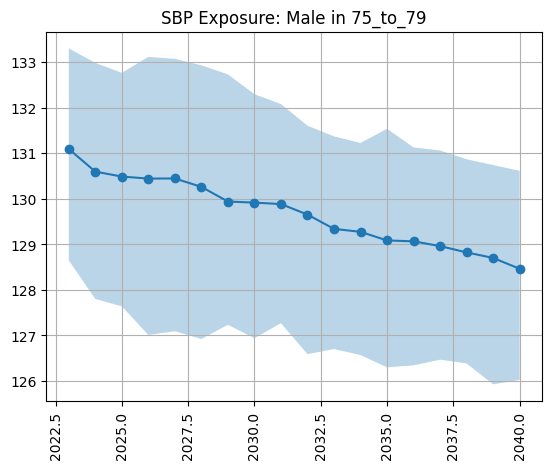

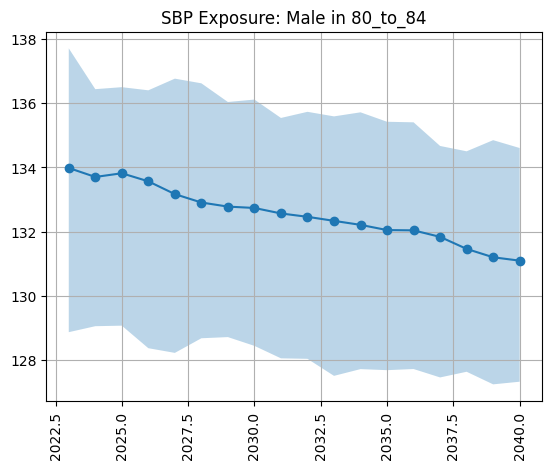

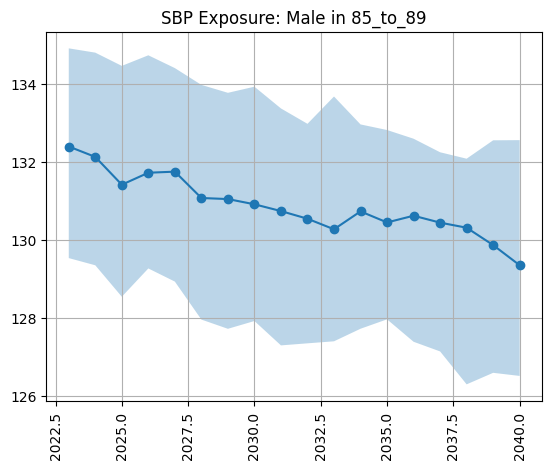

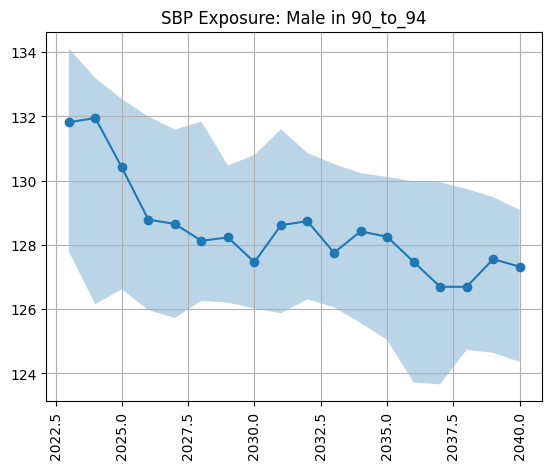

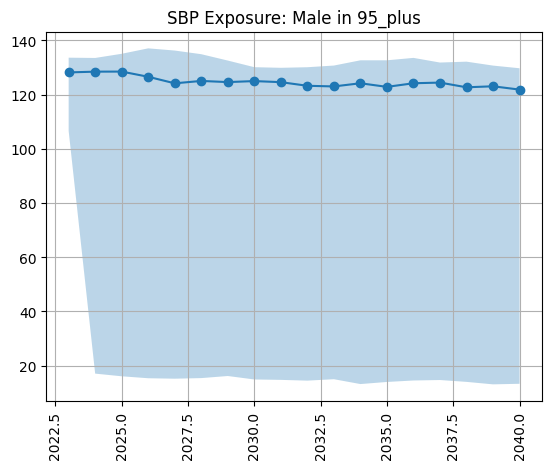

In [15]:
#%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['50%'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

This one is decreasing over time as well... 

### LDL-C

In [16]:
ldl_exp = risk_exp.loc[(risk_exp['risk']=='high_ldl_cholesterol') & (risk_exp['scenario']=='baseline')]
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,2.637453,2.504097,2.837391
1,25_to_29,Female,2024,2.635136,2.514210,2.834904
2,25_to_29,Female,2025,2.631342,2.516686,2.826776
3,25_to_29,Female,2026,2.630735,2.511820,2.825241
4,25_to_29,Female,2027,2.631834,2.507576,2.824659


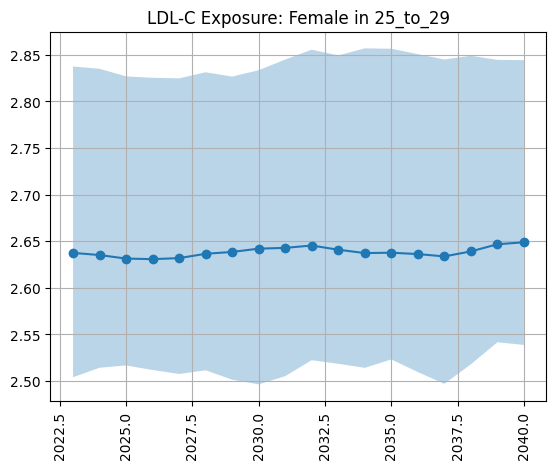

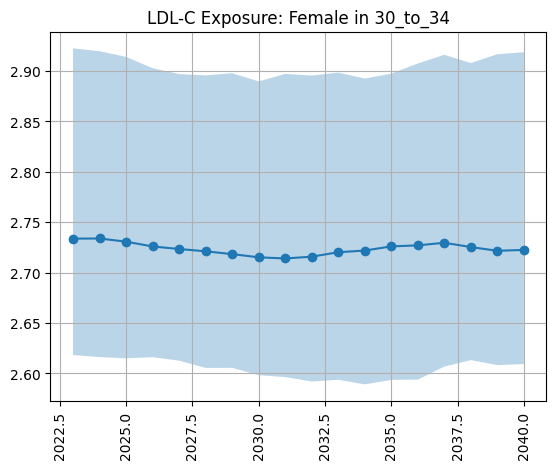

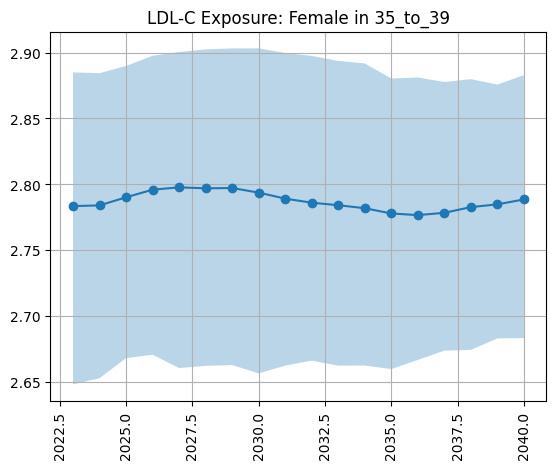

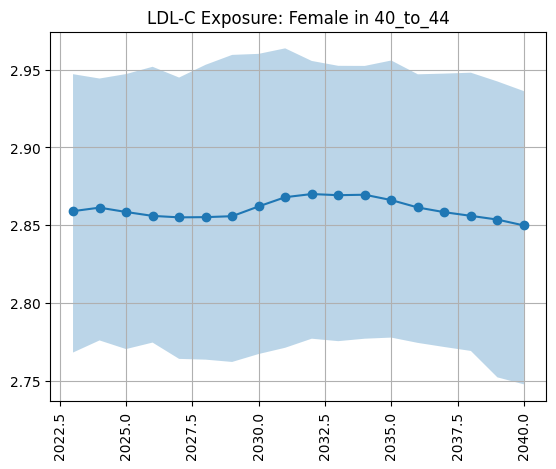

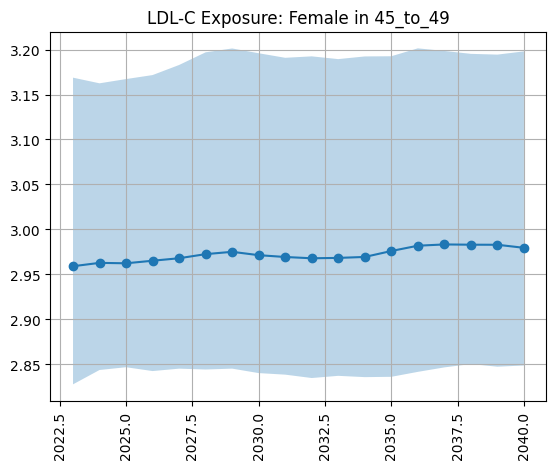

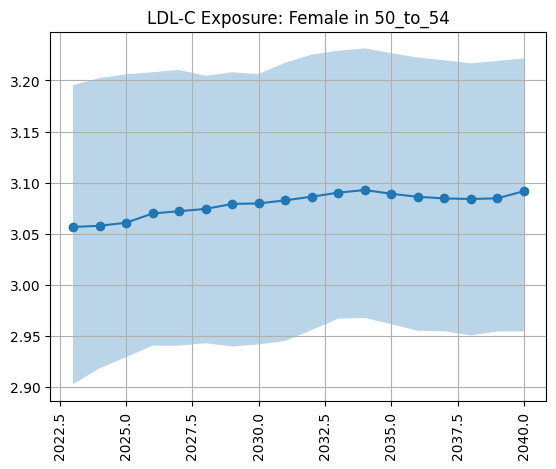

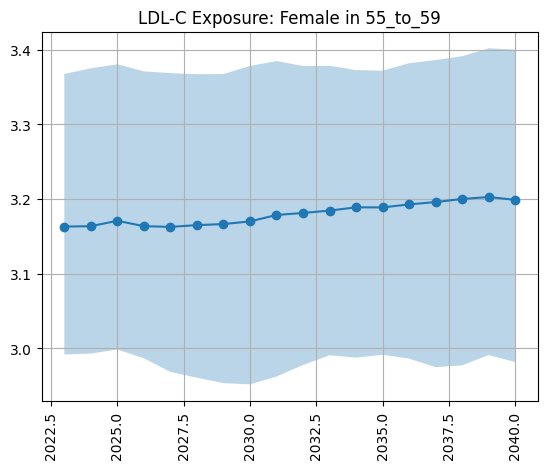

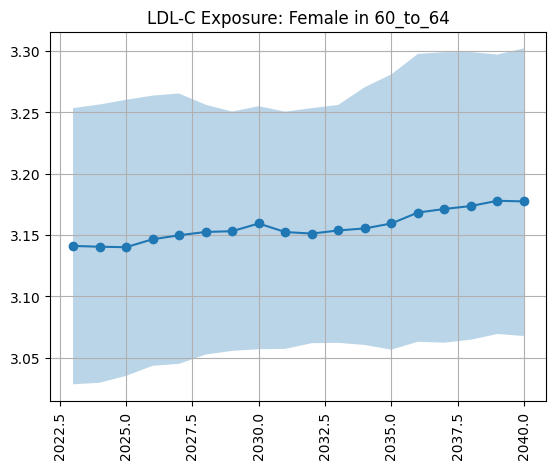

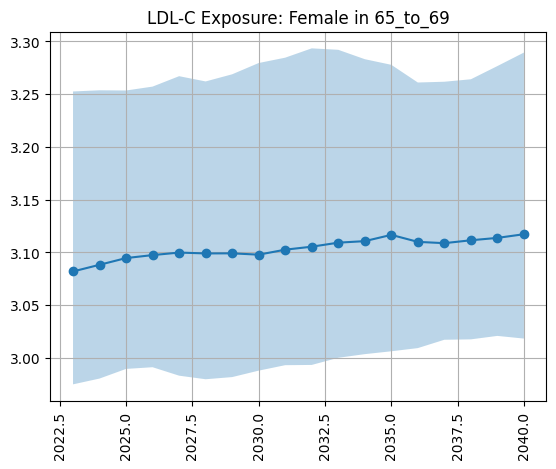

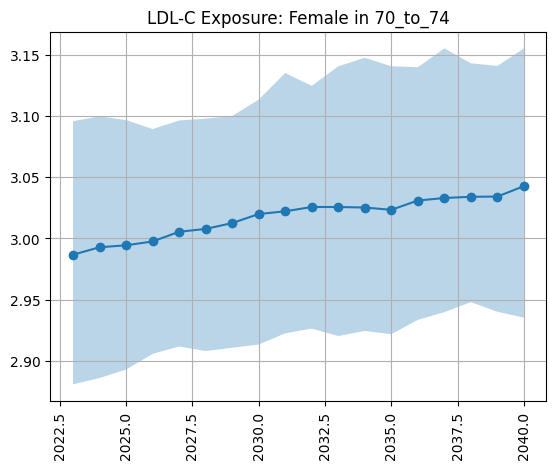

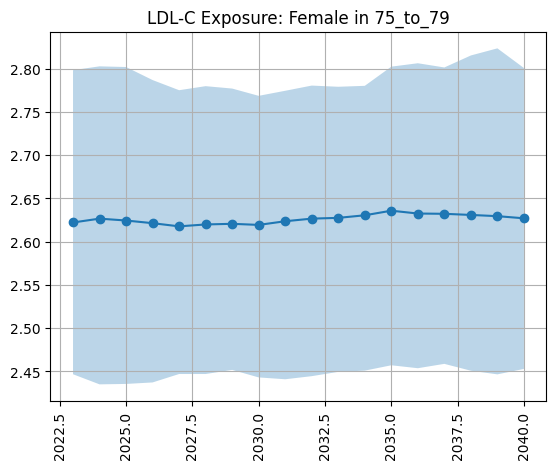

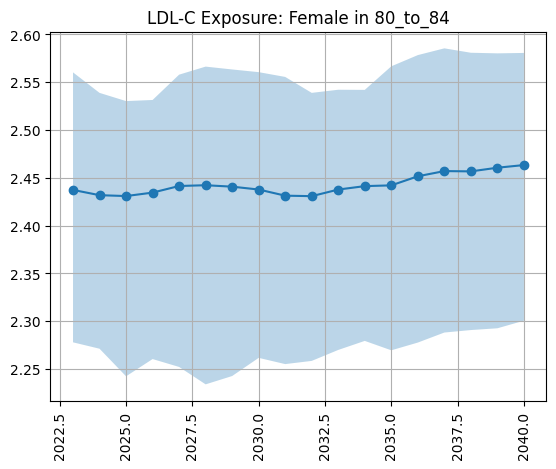

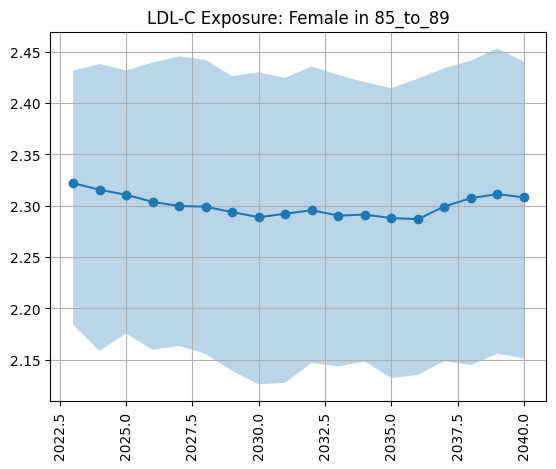

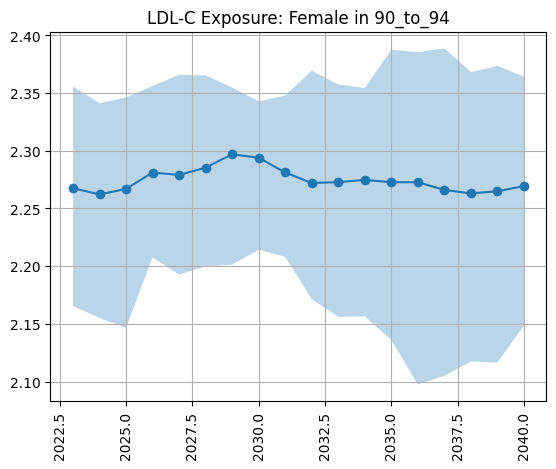

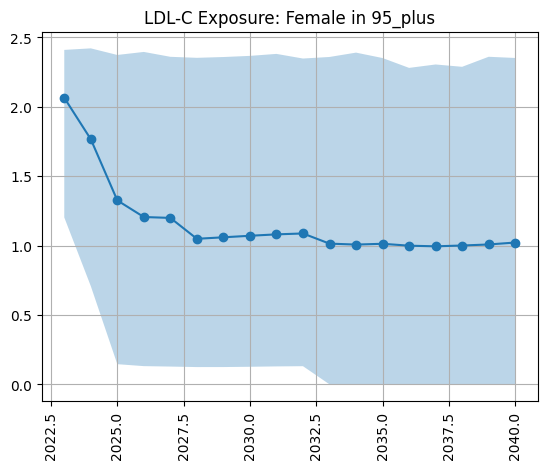

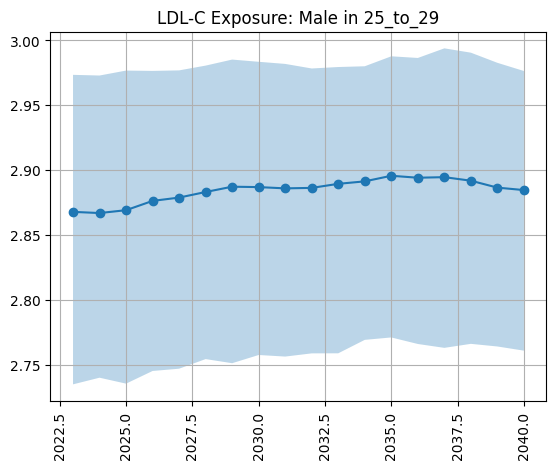

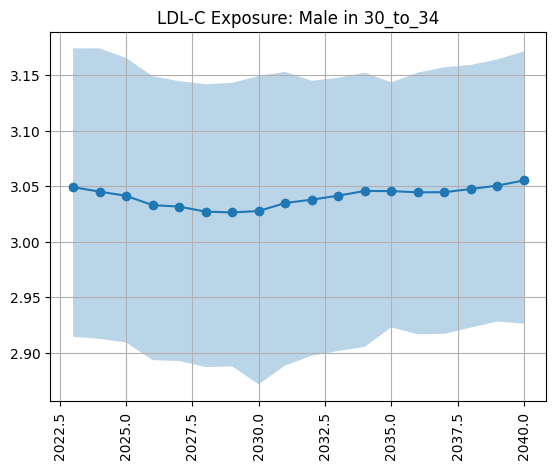

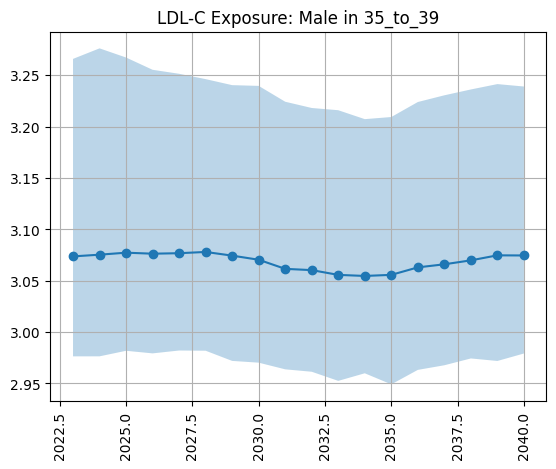

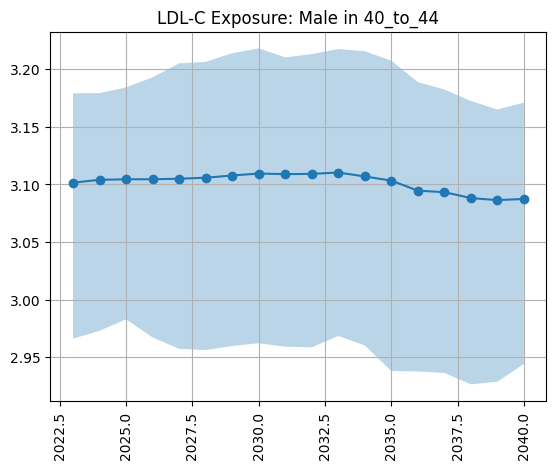

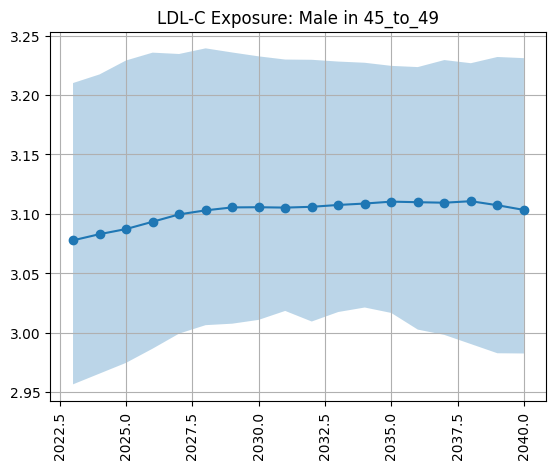

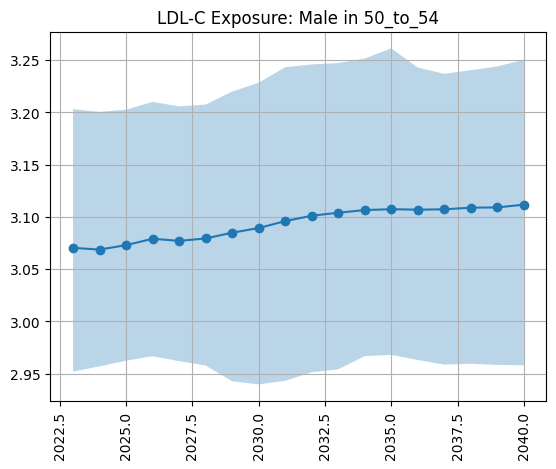

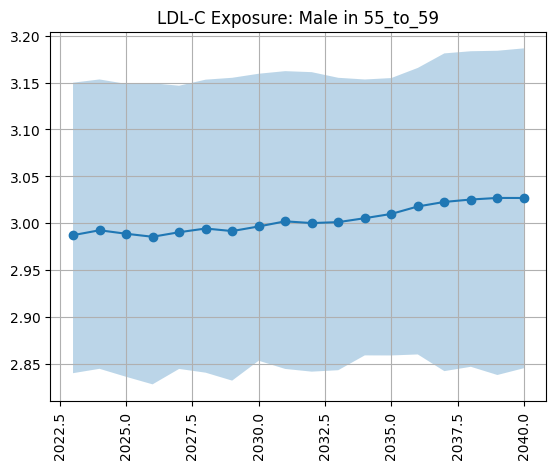

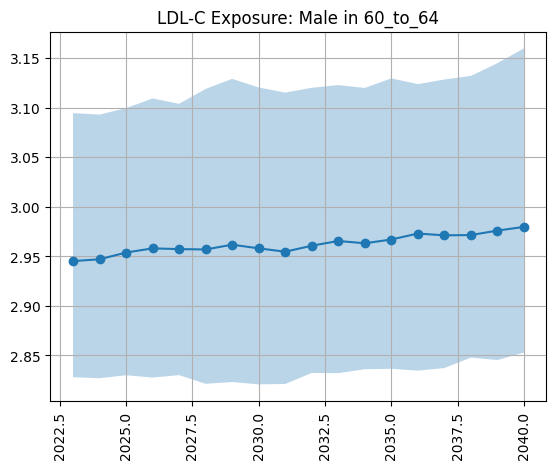

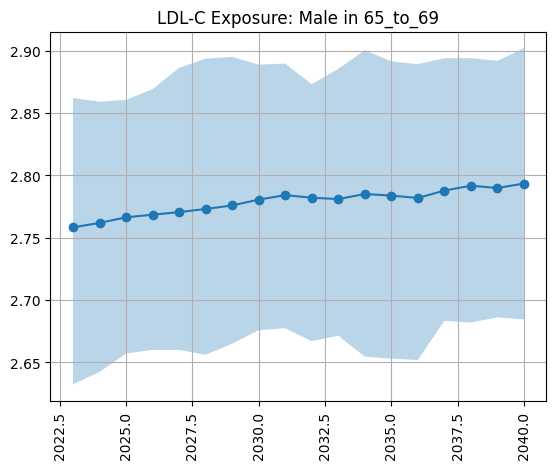

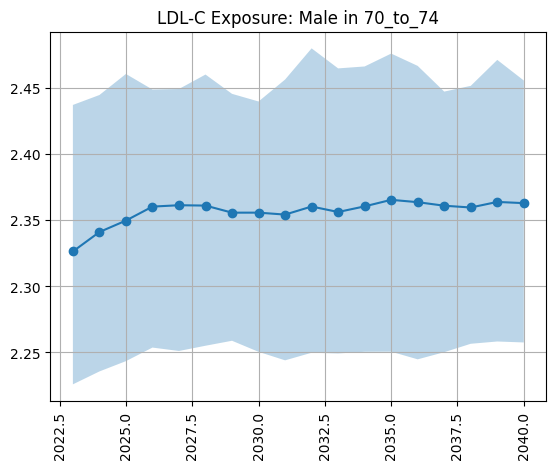

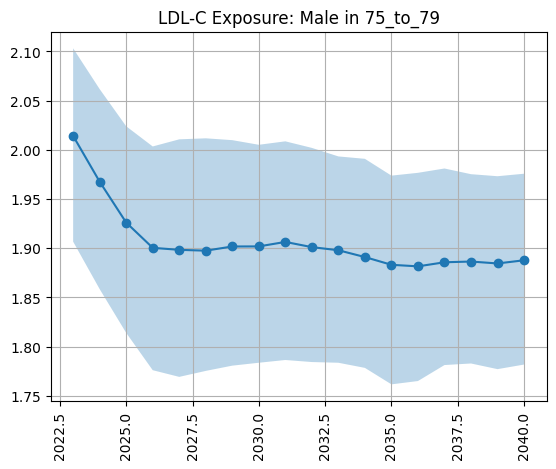

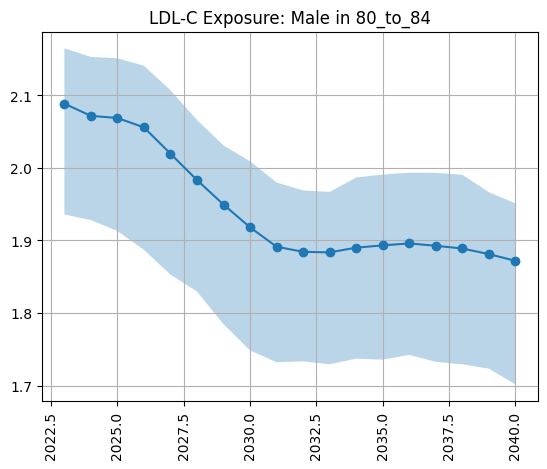

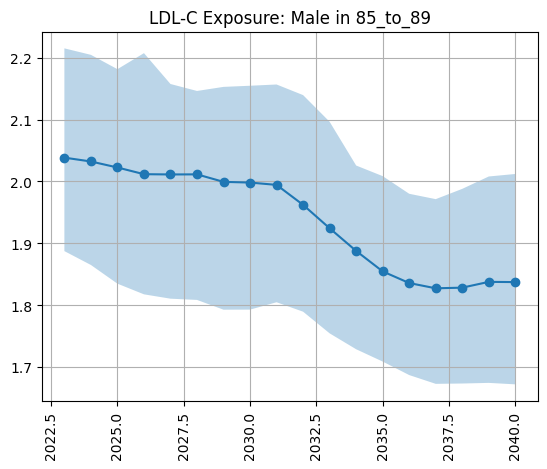

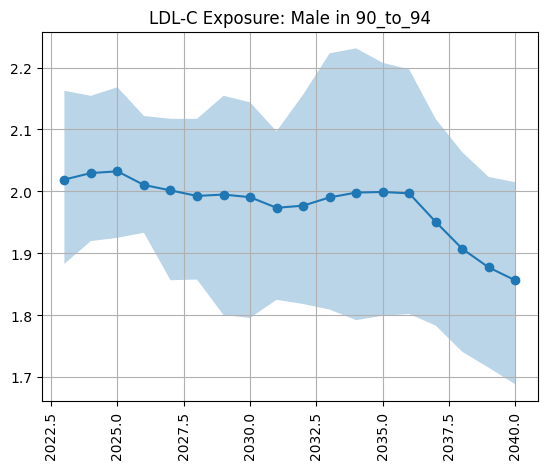

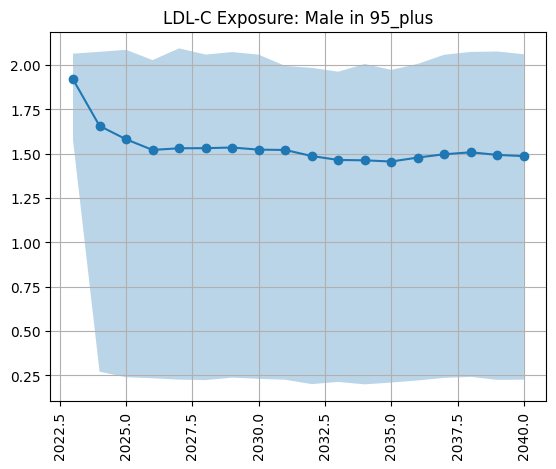

In [17]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

LDL-C increases in some age groups but decreases in the oldest age groups 

### FPG

In [18]:
fpg_exp = risk_exp.loc[(risk_exp['risk']=='high_fasting_plasma_glucose')  & (risk_exp['scenario']=='baseline')]
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,5.188442,4.742404,5.773197
1,25_to_29,Female,2024,5.196752,4.757087,5.781536
2,25_to_29,Female,2025,5.205850,4.760914,5.785087
3,25_to_29,Female,2026,5.213237,4.774009,5.788383
4,25_to_29,Female,2027,5.210160,4.764178,5.788551


In [19]:
%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Even more interestingly, this one looks good and very stable over time 

## Comparison to Artifacts

In [20]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/

alabama.hdf               logs/               ohio.hdf
alaska.hdf                louisiana.hdf       oklahoma.hdf
arizona.hdf               maine.hdf           oregon.hdf
arkansas.hdf              maryland.hdf        paf-calculations/
california.hdf            massachusetts.hdf   pennsylvania.hdf
colorado.hdf              michigan.hdf        rhode_island.hdf
connecticut.hdf           minnesota.hdf       south_carolina.hdf
delaware.hdf              mississippi.hdf     south_dakota.hdf
district_of_columbia.hdf  missouri.hdf        south_dakotatennessee.hdf
florida.hdf               montana.hdf         tennessee.hdf
georgia.hdf               nebraska.hdf        texas.hdf
hawaii.hdf                nevada.hdf          utah.hdf
idaho.hdf                 new_hampshire.hdf   vermont.hdf
illinois.hdf              new_jersey.hdf      virginia.hdf
indiana.hdf               new_mexico.hdf      washington.hdf
iowa.hdf                  new_york.hdf        west_virginia.hdf
kansas.hdf                

In [21]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/rhode_island.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [22]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['rhode_island']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [23]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
#bmi_art.reset_index(inplace=True)
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
#bmi_art['sex'] = np.where(bmi_art['sex'] == 'Female', 'female', 'male')
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,29.368743,29.370724,29.056431,29.702858,Rhode_island,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,30.047610,30.045247,29.716381,30.388666,Rhode_island,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,29.865791,29.866357,29.543779,30.200042,Rhode_island,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,30.090118,30.085126,29.786247,30.412277,Rhode_island,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,30.407137,30.400934,30.072293,30.757735,Rhode_island,exposure,45_to_49


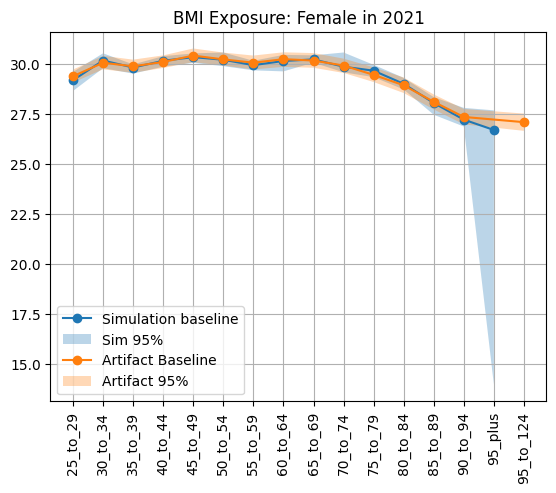

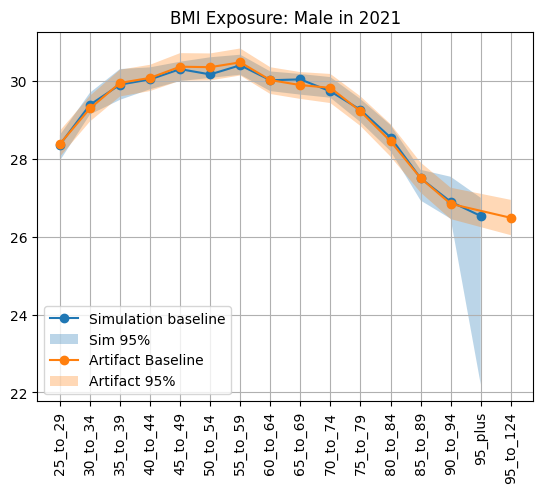

In [24]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

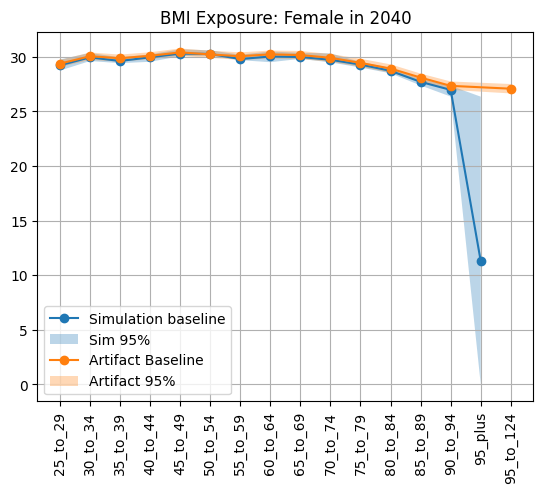

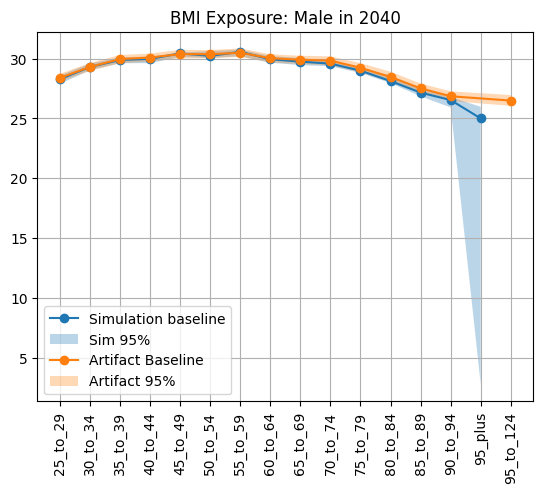

In [25]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [26]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,108.855143,108.911476,106.276716,111.504196,Rhode_island,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,111.009887,111.025818,108.420586,113.649690,Rhode_island,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,113.787747,113.811850,110.959464,116.622587,Rhode_island,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,115.759630,115.747303,113.063693,118.726393,Rhode_island,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,119.286665,119.333451,116.255199,122.310851,Rhode_island,exposure,45_to_49


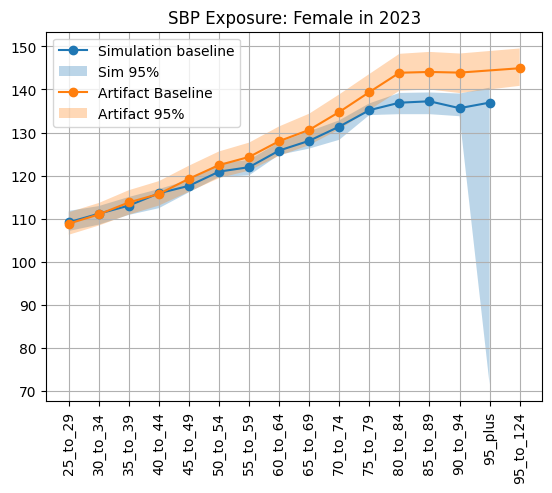

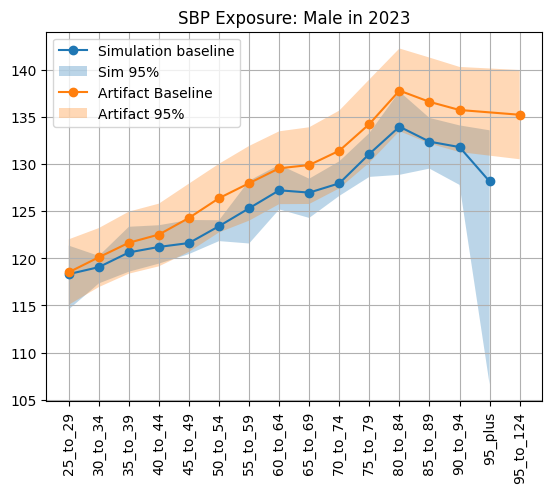

In [27]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

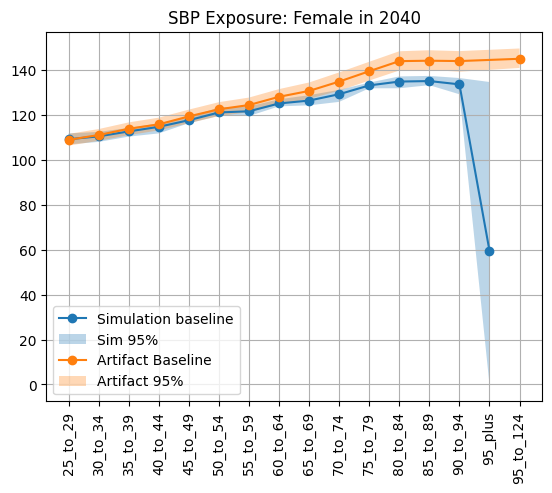

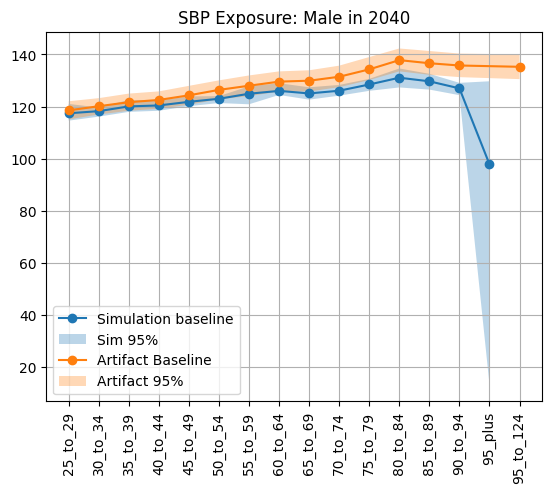

In [28]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [29]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,2.658682,2.657399,2.487218,2.842420,Rhode_island,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,2.744062,2.742132,2.578113,2.932356,Rhode_island,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,2.834472,2.828146,2.661805,3.019590,Rhode_island,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,2.878352,2.876975,2.712222,3.058576,Rhode_island,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,2.996477,2.992760,2.808434,3.199932,Rhode_island,exposure,45_to_49


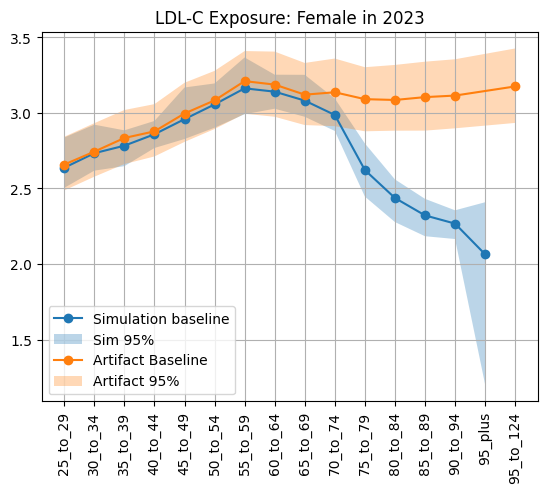

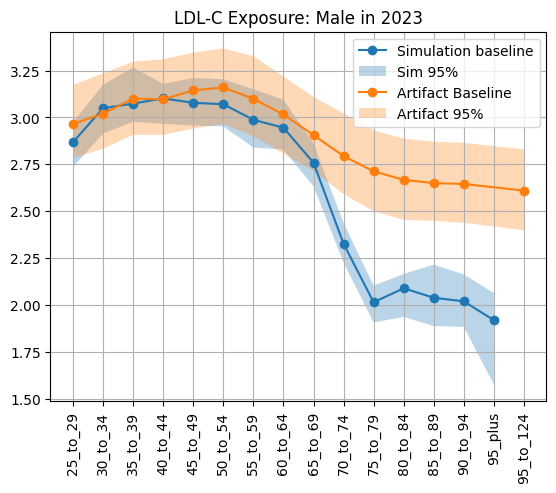

In [30]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

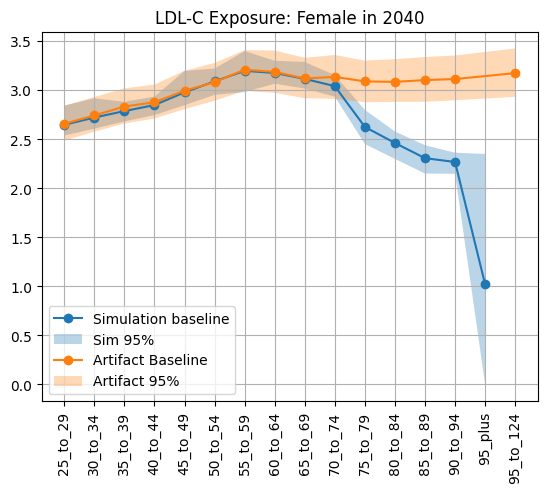

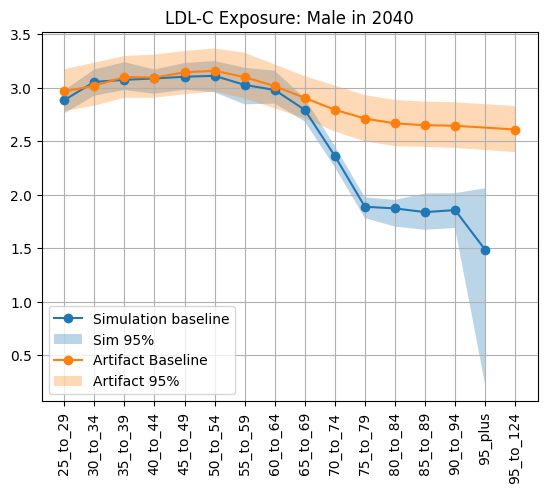

In [31]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [32]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,5.291151,5.275577,4.509716,6.064005,Rhode_island,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,5.417186,5.410483,4.638854,6.180667,Rhode_island,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,5.541881,5.521632,4.762258,6.415455,Rhode_island,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,5.578010,5.549029,4.804744,6.478510,Rhode_island,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,5.700591,5.684088,4.929638,6.632359,Rhode_island,exposure,45_to_49


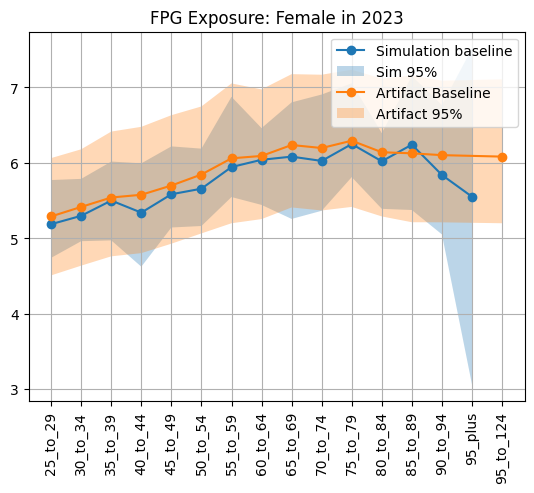

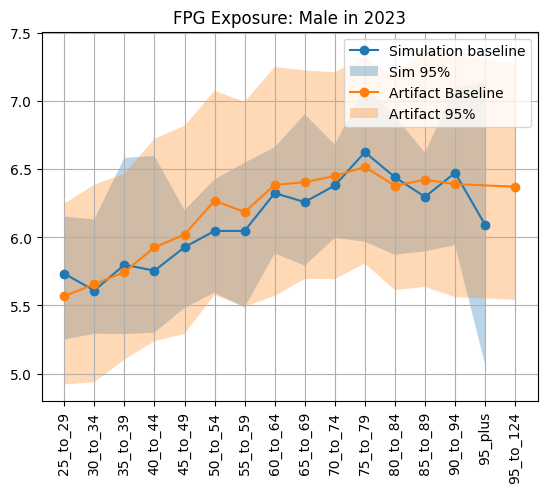

In [33]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

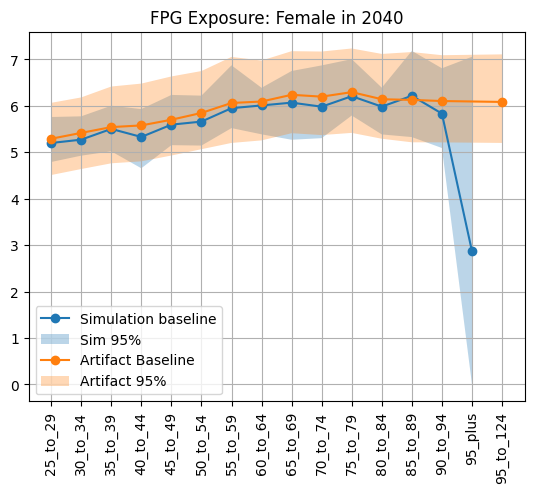

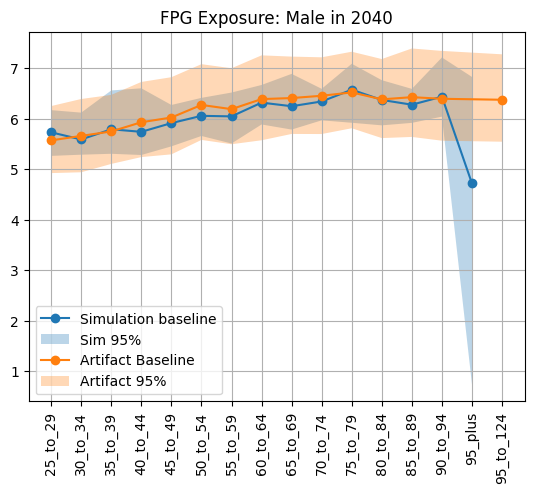

In [34]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad